In [ ]:
import os
from os import listdir, path
import xml.etree.ElementTree as ET
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from keras.models import load_model
import seaborn as sns
import time

#!pip install xmltodict

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/My Drive/Shortcuts for G-Colab/Infotrans')


Mounted at /content/drive


In [ ]:
# Наблюдаемые объекты
cls_dict = {
    'tie_wood': 1,
    'tie_concr': 2,
    'tie_concr_destroyed': 3,
    'tie_concr_ballast': 4,
    'tie_wood_destroyed': 5,
    'tie_wood_ballast': 6,
    'wood_crack': 7,
    'do': 8,
    'hole_do': 9,
    'spring': 10,
    'vossloh': 11,
    'jbr_bracket': 12,
    'jbr_nut': 13,
    'kb': 14,
    'kb_no_bracket': 15,
    'nut': 16,
    'fp_beg': 17,
    'fp_end': 18,
    'rail': 19,
    'joint': 20,
}

In [ ]:
# Пути к папкам с изображениями и аннотациями
images_dir = 'data_1'
annotations_dir = 'data_1'

resize_dim = 256

# Функция для загрузки изображений и их аннотаций
def load_data(images_dir, annotations_dir):
    images = []
    masks = []
    for img_name in os.listdir(images_dir):
        if img_name.endswith('.jpg'):
            # Загрузка изображения
            img_path = os.path.join(images_dir, img_name)
            #print(img_path)
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Загрузка в оттенках серого
            image = cv2.resize(image, (resize_dim, resize_dim))  # Изменение размера
            images.append(image)

            # Парсинг XML для аннотаций
            annotation_path = os.path.join(annotations_dir, img_name.replace('.jpg', '.xml'))
            tree = ET.parse(annotation_path)
            root = tree.getroot()

            # Создаем пустую маску для разметки
            mask = np.zeros((500, 500), dtype=np.uint8)

            # Отрисовка каждого объекта в маске
            for name, label in cls_dict.items():
                for obj in root.findall('object'):
                    if obj.find('name').text == name:
                        bbox = obj.find('bndbox')
                        xmin = int(bbox.find('xmin').text)
                        ymin = int(bbox.find('ymin').text)
                        xmax = int(bbox.find('xmax').text)
                        ymax = int(bbox.find('ymax').text)

                        mask[ymin:ymax, xmin:xmax] = label
            mask = cv2.resize(mask, (resize_dim, resize_dim))
            masks.append(mask)

    return np.array(images), np.array(masks)

# Загрузка данных
images, masks = load_data(images_dir, annotations_dir)
# Проверка формы
print(np.shape(images), np.shape(masks))

(204, 256, 256) (204, 256, 256)


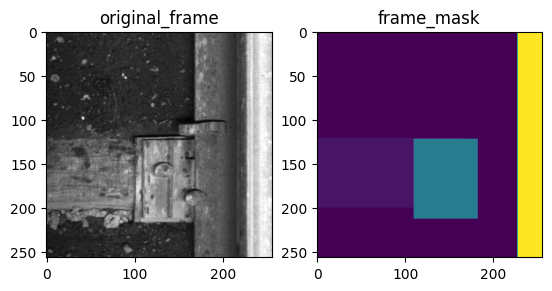

In [ ]:
# Проверка разметки
fig, axs = plt.subplots(1, 2)
axs[0].imshow(images[1], cmap='gray')
axs[0].set_title('original_frame')
axs[1].imshow(masks[1])
#sns.heatmap(masks[0], ax=axs[2])
axs[1].set_title('frame_mask');

In [ ]:
# Разделение на обучающую, валидационную и тестовую выборки
X_train, X_temp, y_train, y_temp = train_test_split(images, masks, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Преобразование данных в формат, подходящий для Keras
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

y_train = np.expand_dims(y_train, axis=-1)
y_val = np.expand_dims(y_val, axis=-1)
y_test = np.expand_dims(y_test, axis=-1)

# Нормализация данных
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

In [ ]:
# U-net for 256x256
from tensorflow.keras import layers, models

def unet_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bottleneck
    conv5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)

    # Decoder
    up6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5)
    up6 = layers.concatenate([up6, conv4])
    conv6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(up6)
    conv6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

    up7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
    up7 = layers.concatenate([up7, conv3])
    conv7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(up7)
    conv7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

    up8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
    up8 = layers.concatenate([up8, conv2])
    conv8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(up8)
    conv8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

    up9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
    up9 = layers.concatenate([up9, conv1])
    conv9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(up9)
    conv9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(conv9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model


model = unet_model((256, 256, 1), 21)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Обучение модели
start_time = time.time()

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=54, batch_size=8)

learn_time = (time.time() - start_time) / len(X_test)
print(f"время обучения: {learn_time:.4f} секунд")

# Сохранение модели
# model.save('Models/new.keras')

Epoch 1/54
21/21 [==============================] - 588s 28s/step - loss: 2.4829 - accuracy: 0.5572 - val_loss: 1.8537 - val_accuracy: 0.5904
Epoch 2/54
21/21 [==============================] - 644s 31s/step - loss: 1.5473 - accuracy: 0.6104 - val_loss: 1.2309 - val_accuracy: 0.5904
Epoch 3/54
21/21 [==============================] - 565s 27s/step - loss: 1.1864 - accuracy: 0.6746 - val_loss: 1.3114 - val_accuracy: 0.6712
Epoch 4/54
21/21 [==============================] - 563s 27s/step - loss: 1.1178 - accuracy: 0.7000 - val_loss: 0.9828 - val_accuracy: 0.6850
Epoch 5/54
21/21 [==============================] - 562s 27s/step - loss: 1.0127 - accuracy: 0.7150 - val_loss: 0.8945 - val_accuracy: 0.7213
Epoch 6/54
21/21 [==============================] - 561s 27s/step - loss: 0.9724 - accuracy: 0.7345 - val_loss: 0.9032 - val_accuracy: 0.7077
Epoch 7/54
21/21 [==============================] - 559s 27s/step - loss: 0.9463 - accuracy: 0.7328 - val_loss: 0.8408 - val_accuracy: 0.7389
Epoch 

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']

plt.figure()
plt.plot(history.epoch, loss, 'r', label='Training loss')
plt.plot(history.epoch, val_loss, 'bo', label='Validation loss')
plt.plot(history.epoch, accuracy, 'g', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
#plt.ylim([0, 1])
plt.legend();

In [ ]:
loaded_model = load_model('U-net_200im_256_54ep_adam.keras')

In [ ]:
from sklearn.metrics import precision_score, jaccard_score

# Предсказание на тестовых данных
y_pred = model.predict(X_test)
# Assuming y_pred has shape (num_samples, height, width, num_classes)
y_pred_classes = np.array([np.argmax(y, axis=-1) for y in y_pred])  # Get the class with the highest probability

# Flatten the arrays for evaluation
y_test_flat = y_test.flatten()
y_pred_flat = y_pred_classes.flatten()

# IoU (Intersection over Union)
iou = jaccard_score(y_test_flat, y_pred_flat, average='weighted')  # Use 'weighted' for multi-class

# Precision
precision = precision_score(y_test_flat, y_pred_flat, average='weighted', labels=np.unique(y_pred_flat))  # Use 'weighted' for multi-class

pixel_score = np.sum(y_pred_flat == y_test_flat) / y_test_flat.size

print(f"IoU: {iou}")
print(f"Precision: {precision}")
print(f"Pixel score: {pixel_score}")


# Оценка производительности (время инференса)
start_time = time.time()
model.predict(X_test)
inference_time = (time.time() - start_time) / len(X_test)
print(f"Среднее время инференса на один кадр: {inference_time:.4f} секунд")


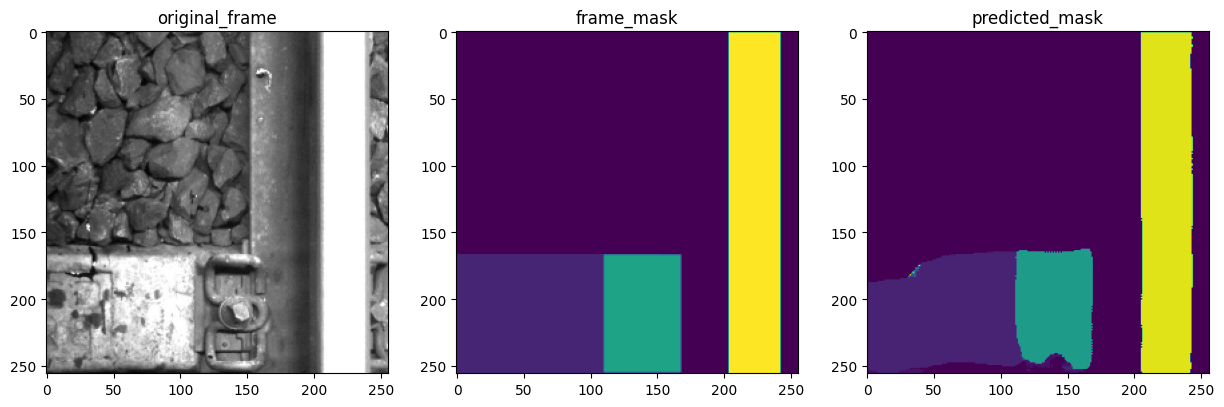

In [ ]:
pic_num = 20

y_pred_classes = np.argmax(y_pred[pic_num], axis=-1)
np.unique(y_pred_classes)
#plt.imshow(y_pred_classes);

fig, axs = plt.subplots(1, 3, figsize=(15, 7))
axs[0].imshow(X_test[pic_num], cmap='gray')
axs[0].set_title('original_frame')
axs[1].imshow(y_test[pic_num])
axs[1].set_title('frame_mask')
axs[2].imshow(y_pred_classes)
axs[2].set_title('predicted_mask');